Processing dataset: MNIST
Processing dataset: CIFAR10
Processing dataset: SVHN


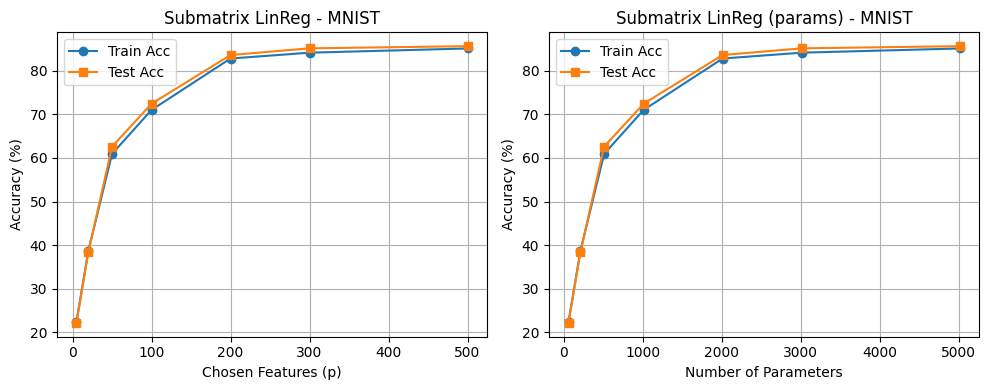

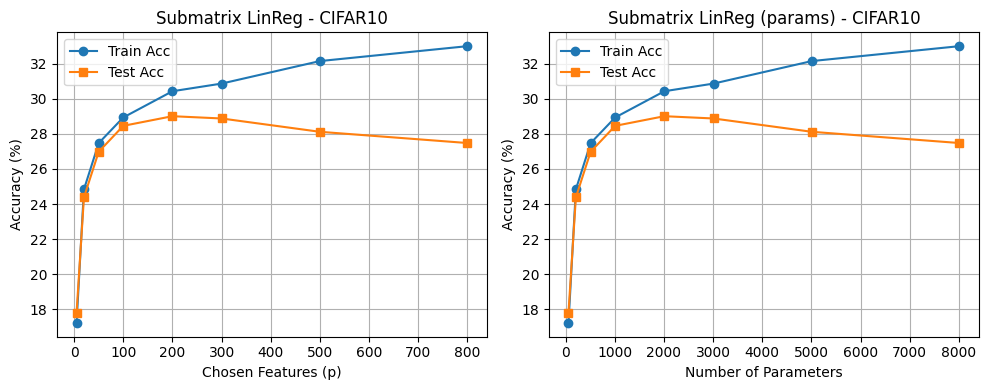

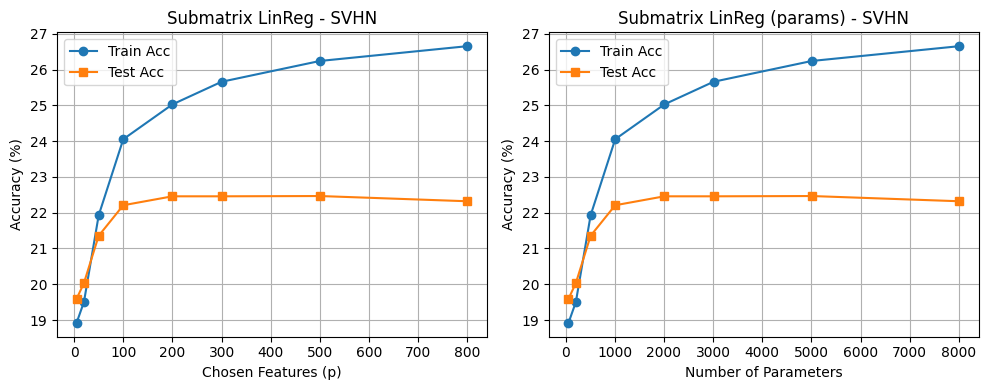

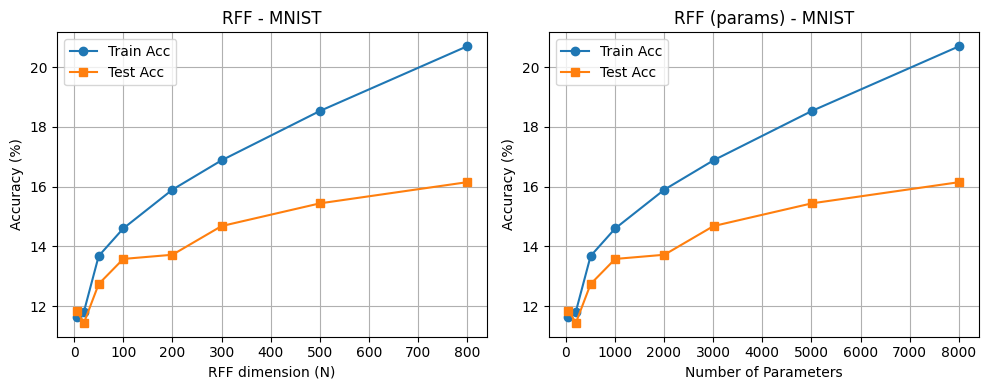

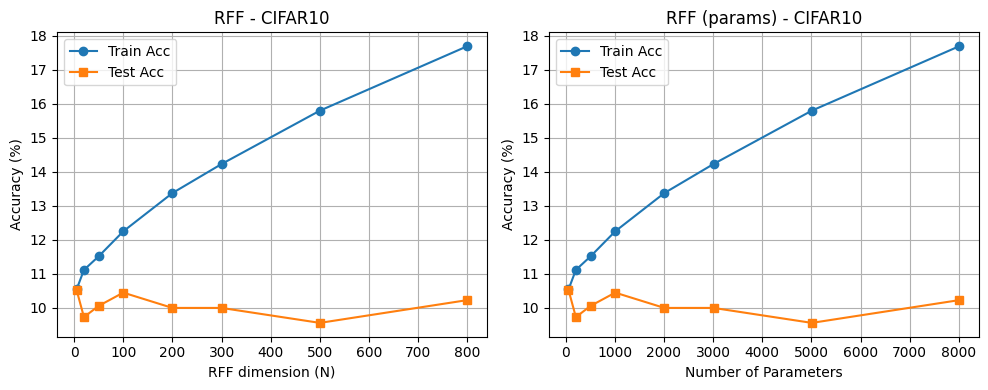

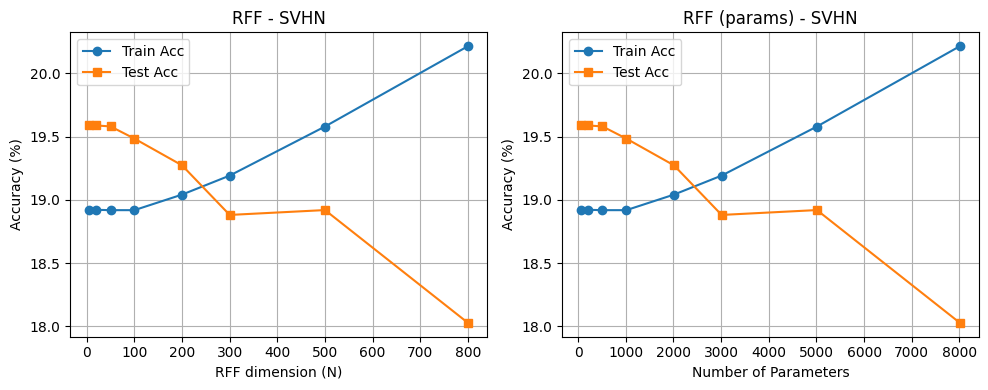

Experiment finished. Plots are shown above. See DataFrames (df_lin_all, df_rff_all) for numeric results.


In [2]:
# Double Descent Experiments
# ===========================
#
# This notebook illustrates the double descent phenomenon using two models:
#  (1) Linear Regression with a sub-selected p-submatrix approach
#  (2) Linear Regression on Random Fourier Features (RFF)
#
# Datasets:
#  - MNIST
#  - CIFAR-10
#  - SVHN
#
# The code below:
#  1. Loads and preprocesses each dataset (grayscale, flattened, standardized).
#  2. Defines a random submatrix experiment (linear regression on p randomly chosen features).
#  3. Defines an RFF experiment (map to N-dimensional RFF, then do ridge regression).
#  4. Varies p or N across a range to observe double descent curves.
#  5. Stores results (train/test accuracy) and visualizes them.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10
from scipy.io import loadmat  # for SVHN .mat files

from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


########################################################################
# 1. DATA LOADING AND PREPROCESSING
########################################################################

def load_mnist():
    """
    Loads the MNIST dataset using Keras.
    Returns: (x_train, y_train, x_test, y_test).
    Each image is flattened to (784, ) and normalized to [0,1].
    """
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape((-1, 28*28)) / 255.0
    x_test  = x_test.reshape((-1, 28*28))  / 255.0
    return (x_train, y_train, x_test, y_test)

def load_cifar10():
    """
    Loads the CIFAR-10 dataset, converts to grayscale, flattens, normalizes to [0,1].
    Returns: (x_train, y_train, x_test, y_test).
    """
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Convert to grayscale: shape => (N,32,32,1)
    x_train_gray = tf.image.rgb_to_grayscale(x_train).numpy()
    x_test_gray  = tf.image.rgb_to_grayscale(x_test).numpy()
    # Flatten => (N, 32*32), normalized
    x_train_gray = x_train_gray.reshape((-1, 32*32)) / 255.0
    x_test_gray  = x_test_gray.reshape((-1, 32*32))  / 255.0
    # Flatten labels
    y_train = y_train.flatten()
    y_test  = y_test.flatten()
    return (x_train_gray, y_train, x_test_gray, y_test)

def load_svhn(path_train='train_32x32.mat', path_test='test_32x32.mat'):
    """
    Loads SVHN dataset from .mat files (train/test sets).
    Converts to grayscale, flattens, normalizes to [0,1].
    Returns: (x_train, y_train, x_test, y_test).
    """
    train_dict = loadmat(path_train)
    x_train = train_dict['X']  # shape (32,32,3,N)
    y_train = train_dict['y']  # shape (N,1)

    x_train = np.transpose(x_train, (3,0,1,2))  # => (N,32,32,3)
    y_train = y_train.flatten()
    # In SVHN, digit '10' is '0'
    y_train[y_train == 10] = 0

    test_dict = loadmat(path_test)
    x_test = test_dict['X']
    y_test = test_dict['y']
    x_test = np.transpose(x_test, (3,0,1,2))
    y_test = y_test.flatten()
    y_test[y_test == 10] = 0

    # Convert to grayscale, flatten
    x_train_gray = tf.image.rgb_to_grayscale(x_train).numpy()
    x_test_gray  = tf.image.rgb_to_grayscale(x_test).numpy()
    x_train_gray = x_train_gray.reshape((-1, 32*32)) / 255.0
    x_test_gray  = x_test_gray.reshape((-1, 32*32))  / 255.0

    return (x_train_gray, y_train, x_test_gray, y_test)

# Load each dataset
(x_mnist_tr, y_mnist_tr, x_mnist_te, y_mnist_te) = load_mnist()
(x_cifar_tr, y_cifar_tr, x_cifar_te, y_cifar_te) = load_cifar10()
(x_svhn_tr,  y_svhn_tr,  x_svhn_te,  y_svhn_te)  = load_svhn('data/SVHN/train_32x32.mat','data/SVHN/test_32x32.mat')

# Put them in a dictionary
datasets = {
    'MNIST':   (x_mnist_tr,  y_mnist_tr, x_mnist_te,  y_mnist_te),
    'CIFAR10': (x_cifar_tr,  y_cifar_tr, x_cifar_te,  y_cifar_te),
    'SVHN':    (x_svhn_tr,   y_svhn_tr,  x_svhn_te,   y_svhn_te)
}

def standardize_data(x_train, x_test):
    """
    Standardizes features to zero mean, unit variance.
    """
    scaler = StandardScaler()
    x_train_s = scaler.fit_transform(x_train)
    x_test_s  = scaler.transform(x_test)
    return (x_train_s, x_test_s)


########################################################################
# 2. LINEAR REGRESSION WITH RANDOM p-SUBMATRIX
########################################################################
# We'll do classification by a one-vs-rest ridge regression approach.

def fit_ridge_multiclass(X, Y, alpha=1e-6):
    """
    Fits a set of ridge regressors in one-vs-rest fashion for a classification problem.
    X: (N, p)  features
    Y: (N,)    integer labels
    alpha: regularization strength
    Returns a list of (coef, intercept) for each class.
    """
    classes = np.unique(Y)
    W = []
    from sklearn.linear_model import Ridge
    for c in classes:
        y_bin = (Y == c).astype(np.float32)
        reg = Ridge(alpha=alpha, fit_intercept=True)
        reg.fit(X, y_bin)
        W.append((reg.coef_, reg.intercept_))
    return (W, classes)

def predict_ridge_multiclass(X, W, classes):
    """
    Predicts labels from one-vs-rest ridge model.
    W: list of (coef, intercept)
    classes: array of possible class labels
    """
    n_classes = len(W)
    N = X.shape[0]
    scores = np.zeros((N, n_classes), dtype=np.float32)
    for idx, (w_c, b_c) in enumerate(W):
        scores[:, idx] = X.dot(w_c) + b_c
    # Argmax
    pred_idx = np.argmax(scores, axis=1)
    return classes[pred_idx]

def random_submatrix_experiment(x_train, y_train, x_test, y_test, p_values, alpha=1e-6):
    """
    For each p in p_values:
      1) randomly choose p features out of d
      2) fit ridge OVR
      3) evaluate train/test accuracy
    Returns a DataFrame with columns: p, n_params, train_acc, test_acc
    """
    results = []
    d = x_train.shape[1]
    classes = np.unique(y_train)
    C = len(classes)

    for p in p_values:
        # Randomly select p features
        if p > d:
            continue
        features_idx = np.random.choice(d, size=p, replace=False)
        Xtr = x_train[:, features_idx]
        Xte = x_test[:,  features_idx]

        # Fit
        W_fit, class_vals = fit_ridge_multiclass(Xtr, y_train, alpha=alpha)
        # Predict
        y_pred_tr = predict_ridge_multiclass(Xtr, W_fit, class_vals)
        y_pred_te = predict_ridge_multiclass(Xte, W_fit, class_vals)
        train_acc = 100.0 * np.mean(y_pred_tr == y_train)
        test_acc  = 100.0 * np.mean(y_pred_te == y_test)
        # number of parameters ~ p*C + C intercept
        n_params = p*C + C

        results.append({
            'p': p,
            'n_params': n_params,
            'train_acc': train_acc,
            'test_acc':  test_acc
        })
    df = pd.DataFrame(results)
    return df


########################################################################
# 3. RANDOM FOURIER FEATURES (RFF) + LINEAR REGRESSION
########################################################################

def build_rff_map(x, n_components=100, gamma=0.05, random_state=42):
    """
    Build RFF features for each sample in x.
    RFF dimension = n_components
    gamma ~ 1/(2*sigma^2) => sigma^2 = 1/(2 gamma)
    We'll do Z_j = sqrt(2/N)*cos(xW + b).
    """
    np.random.seed(random_state)
    N_ = x.shape[0]
    d  = x.shape[1]
    # sample w: shape(d, n_components)
    W = np.random.normal(0.0, np.sqrt(2*gamma), size=(d, n_components))
    b = np.random.uniform(0.0, 2*np.pi, size=(n_components,))
    # compute xW + b => shape(N, n_components)
    proj = x @ W + b
    Z = np.cos(proj) * np.sqrt(2.0 / n_components)
    return Z

def rff_experiment(x_train, y_train, x_test, y_test, N_values, gamma=0.05, alpha=1e-6):
    """
    For each N in N_values:
      1) Build RFF dimension N
      2) Fit ridge OVR on Z_train
      3) Evaluate on Z_test
    Returns a DataFrame: columns N, n_params, train_acc, test_acc
    """
    results = []
    C = len(np.unique(y_train))
    for N in N_values:
        # Build RFF
        Ztr = build_rff_map(x_train, n_components=N, gamma=gamma)
        Zte = build_rff_map(x_test,  n_components=N, gamma=gamma)
        # Fit
        W_fit, classes = fit_ridge_multiclass(Ztr, y_train, alpha=alpha)
        # Predict
        y_pred_tr = predict_ridge_multiclass(Ztr, W_fit, classes)
        y_pred_te = predict_ridge_multiclass(Zte, W_fit, classes)
        train_acc = 100.0 * np.mean(y_pred_tr == y_train)
        test_acc  = 100.0 * np.mean(y_pred_te == y_test)
        n_params = N*C + C

        results.append({
            'N': N,
            'n_params': n_params,
            'train_acc': train_acc,
            'test_acc':  test_acc
        })
    return pd.DataFrame(results)


########################################################################
# 4. MAIN DRIVER: Gather Results
########################################################################

p_values = [5, 20, 50, 100, 200, 300, 500, 800]
N_values = [5, 20, 50, 100, 200, 300, 500, 800]

all_lin_dfs = []
all_rff_dfs = []

for ds_name, (Xtr, Ytr, Xte, Yte) in datasets.items():
    print(f"Processing dataset: {ds_name}")
    # Standardize
    Xtr_s, Xte_s = standardize_data(Xtr, Xte)

    # 1) Submatrix linear experiment
    d_ = Xtr_s.shape[1]
    p_ok = [p for p in p_values if p <= d_]  # can't exceed dimension
    if len(p_ok) > 0:
        df_lin = random_submatrix_experiment(Xtr_s, Ytr, Xte_s, Yte, p_ok, alpha=1e-6)
        df_lin['dataset'] = ds_name
        all_lin_dfs.append(df_lin)
    else:
        print("  Skipping submatrix: not enough features for smallest p.")

    # 2) RFF experiment
    # Let's fix gamma=0.05 for demonstration
    df_rff = rff_experiment(Xtr_s, Ytr, Xte_s, Yte, N_values, gamma=0.05, alpha=1e-6)
    df_rff['dataset'] = ds_name
    all_rff_dfs.append(df_rff)

df_lin_all = pd.concat(all_lin_dfs, ignore_index=True) if len(all_lin_dfs) else None
df_rff_all = pd.concat(all_rff_dfs, ignore_index=True) if len(all_rff_dfs) else None


########################################################################
# 5. VISUALIZATION
########################################################################

def plot_double_descent_submatrix(df_lin, dataset_name):
    """
    Plots train/test accuracy vs. p (and vs. #params) for the random submatrix approach.
    """
    sub = df_lin[df_lin['dataset'] == dataset_name]
    if sub.empty: return
    sub = sub.sort_values(by='p')
    
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.plot(sub['p'], sub['train_acc'], 'o-', label='Train Acc')
    plt.plot(sub['p'], sub['test_acc'], 's-', label='Test Acc')
    plt.xlabel('Chosen Features (p)')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Submatrix LinReg - {dataset_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(sub['n_params'], sub['train_acc'], 'o-', label='Train Acc')
    plt.plot(sub['n_params'], sub['test_acc'], 's-', label='Test Acc')
    plt.xlabel('Number of Parameters')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Submatrix LinReg (params) - {dataset_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_double_descent_rff(df_rff, dataset_name):
    """
    Plots train/test accuracy vs. RFF dimension (N) (and vs. #params) for the RFF approach.
    """
    sub = df_rff[df_rff['dataset'] == dataset_name]
    if sub.empty: return
    sub = sub.sort_values(by='N')
    
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.plot(sub['N'], sub['train_acc'], 'o-', label='Train Acc')
    plt.plot(sub['N'], sub['test_acc'], 's-', label='Test Acc')
    plt.xlabel('RFF dimension (N)')
    plt.ylabel('Accuracy (%)')
    plt.title(f'RFF - {dataset_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(sub['n_params'], sub['train_acc'], 'o-', label='Train Acc')
    plt.plot(sub['n_params'], sub['test_acc'], 's-', label='Test Acc')
    plt.xlabel('Number of Parameters')
    plt.ylabel('Accuracy (%)')
    plt.title(f'RFF (params) - {dataset_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# Actually generate plots
if df_lin_all is not None:
    for ds_name in df_lin_all['dataset'].unique():
        plot_double_descent_submatrix(df_lin_all, ds_name)

if df_rff_all is not None:
    for ds_name in df_rff_all['dataset'].unique():
        plot_double_descent_rff(df_rff_all, ds_name)

print("Experiment finished. Plots are shown above. See DataFrames (df_lin_all, df_rff_all) for numeric results.")


Processing dataset: MNIST
  Submatrix linear experiment completed in 0.02 s
  RFF experiment completed in 233.74 s
Processing dataset: CIFAR10
  Submatrix linear experiment completed in 0.02 s
  RFF experiment completed in 223.51 s
Processing dataset: SVHN
  Submatrix linear experiment completed in 0.06 s
  RFF experiment completed in 317.76 s


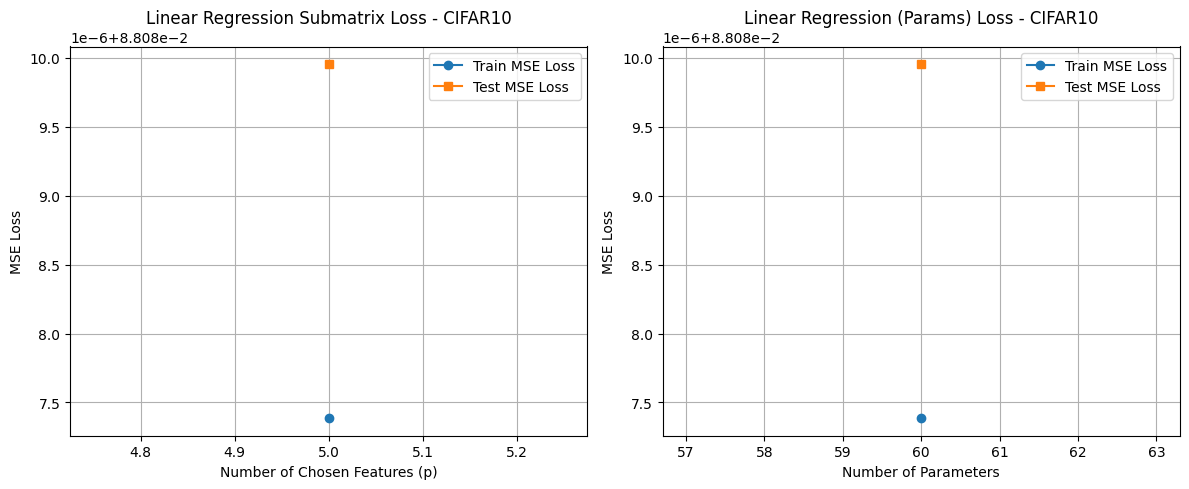

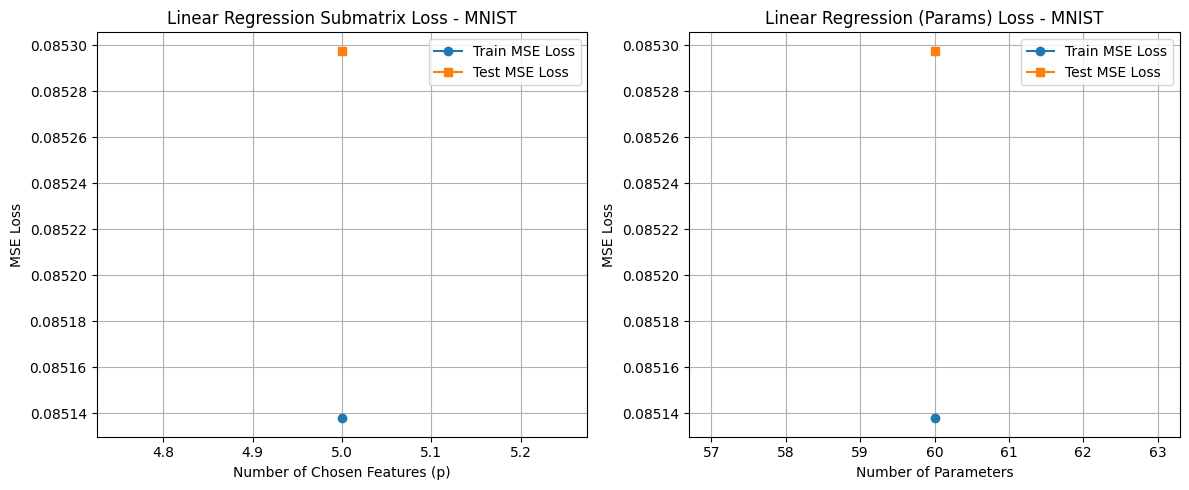

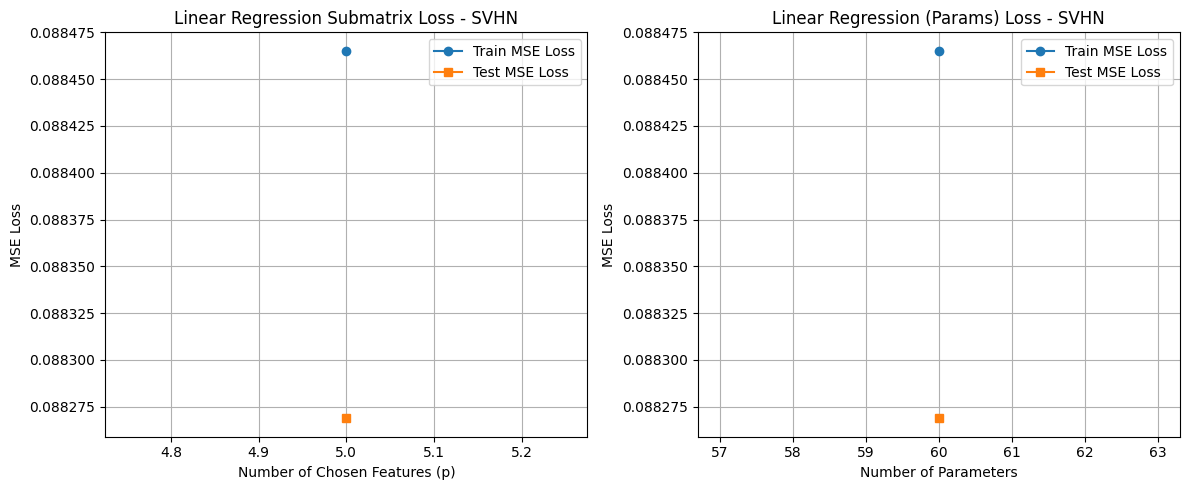

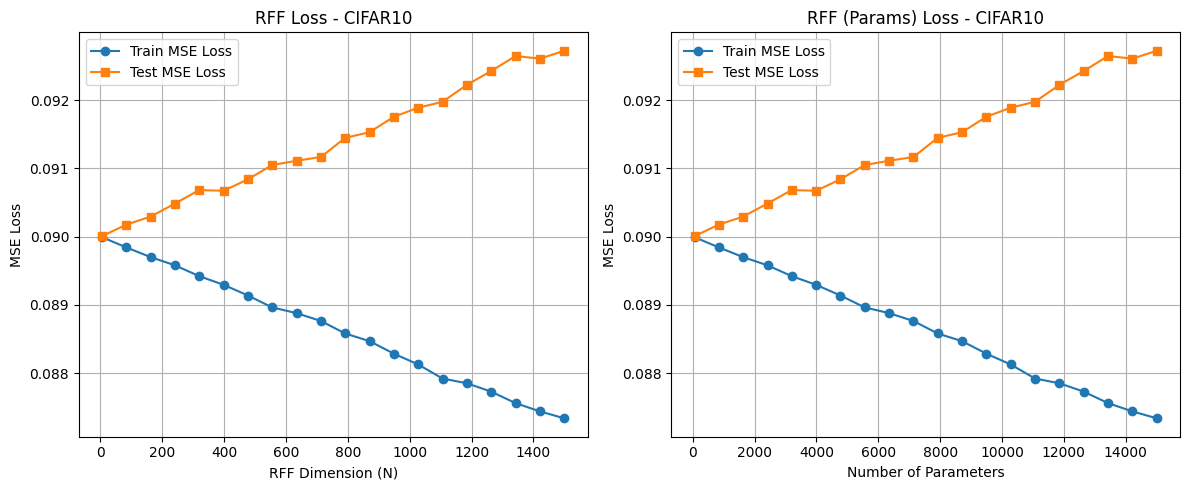

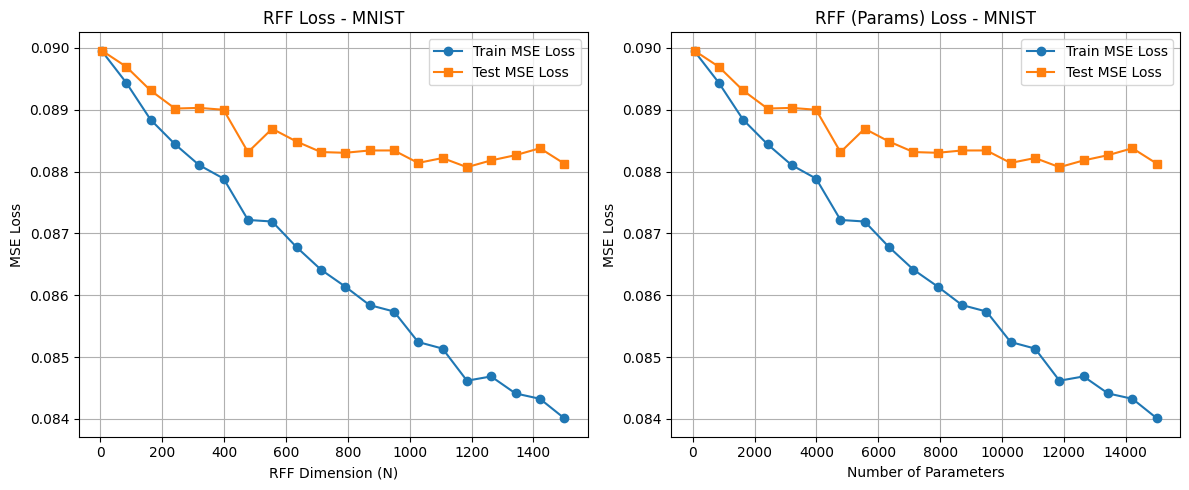

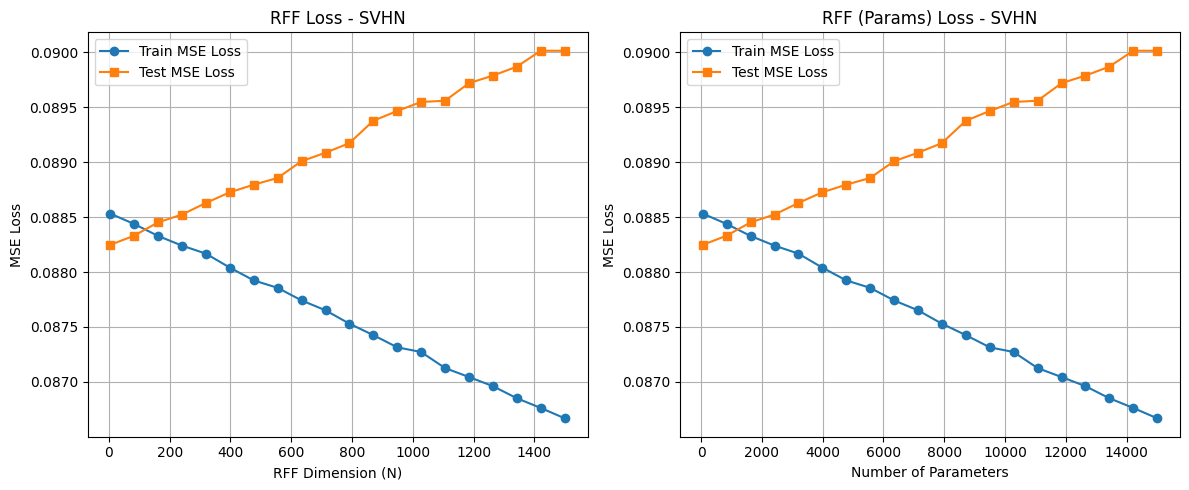

Experiments complete. Loss curves are plotted above. Results are stored in df_lin_all and df_rff_all.


In [1]:
###############################################
# Double Descent Experiments: Loss Curves
# ===========================================
#
# This notebook illustrates the double descent phenomenon using two models:
#  (1) Linear Regression with a sub-selected p-submatrix approach.
#  (2) Linear Regression on Random Fourier Features (RFF).
#
# Datasets used: MNIST, CIFAR-10, SVHN.
#
# In this notebook we focus solely on the linear (and RFF-based) models and we 
# plot training and test MSE (mean squared error) rather than accuracy.
#
# The code below:
#  1. Loads and preprocesses each dataset (grayscale, flattening, and standardization).
#  2. For the linear regression experiment, it randomly selects p features (submatrix)
#     and fits a Ridge regression in a one-vs-rest fashion (for multiclass classification)
#     then computes the MSE between the predicted scores and the one-hot ground truth.
#  3. For the RFF experiment, it first maps the input to RFF features of dimension N, then
#     fits a similar one-vs-rest Ridge regression, and computes the MSE.
#  4. It repeats these experiments over a dense grid of capacities (p for linear and N for RFF)
#     to produce a detailed evolution of the loss as a function of the number of parameters.
#  5. Finally, it plots the loss curves (both training and test loss) as functions of the effective 
#     number of parameters.
#
# All key steps in the code are commented.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10
from scipy.io import loadmat  # Used to load the SVHN .mat files

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ---------------------------
# 1. Data Loading and Preprocessing
# ---------------------------

def load_mnist():
    """Loads MNIST dataset, flattens the images to vectors of length 784, and normalizes to [0,1]."""
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape((-1, 28*28)) / 255.0
    x_test  = x_test.reshape((-1, 28*28))  / 255.0
    return (x_train, y_train, x_test, y_test)

def load_cifar10():
    """Loads CIFAR-10, converts to grayscale, reshapes to vectors of length 1024, and normalizes."""
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Convert RGB to grayscale
    x_train_gray = tf.image.rgb_to_grayscale(x_train).numpy()
    x_test_gray  = tf.image.rgb_to_grayscale(x_test).numpy()
    x_train_gray = x_train_gray.reshape((-1, 32*32)) / 255.0
    x_test_gray  = x_test_gray.reshape((-1, 32*32))  / 255.0
    y_train = y_train.flatten()
    y_test  = y_test.flatten()
    return (x_train_gray, y_train, x_test_gray, y_test)

def load_svhn(path_train='train_32x32.mat', path_test='test_32x32.mat'):
    """Loads SVHN dataset from .mat files, converts to grayscale, flattens, and normalizes."""
    train_dict = loadmat(path_train)
    x_train = train_dict['X']  # shape (32,32,3,N)
    y_train = train_dict['y']  # shape (N,1)
    x_train = np.transpose(x_train, (3, 0, 1, 2))  # => (N,32,32,3)
    y_train = y_train.flatten()
    y_train[y_train == 10] = 0  # In SVHN, label '10' means '0'

    test_dict = loadmat(path_test)
    x_test = test_dict['X']
    y_test = test_dict['y']
    x_test = np.transpose(x_test, (3, 0, 1, 2))
    y_test = y_test.flatten()
    y_test[y_test == 10] = 0

    # Convert to grayscale and flatten
    x_train_gray = tf.image.rgb_to_grayscale(x_train).numpy()
    x_test_gray  = tf.image.rgb_to_grayscale(x_test).numpy()
    x_train_gray = x_train_gray.reshape((-1, 32*32)) / 255.0
    x_test_gray  = x_test_gray.reshape((-1, 32*32))  / 255.0
    return (x_train_gray, y_train, x_test_gray, y_test)

# Load datasets and store in a dictionary
(x_mnist_tr, y_mnist_tr, x_mnist_te, y_mnist_te) = load_mnist()
(x_cifar_tr, y_cifar_tr, x_cifar_te, y_cifar_te) = load_cifar10()
(x_svhn_tr, y_svhn_tr, x_svhn_te, y_svhn_te) = load_svhn('data/SVHN/train_32x32.mat','data/SVHN/test_32x32.mat')

datasets = {
    'MNIST':   (x_mnist_tr,  y_mnist_tr, x_mnist_te,  y_mnist_te),
    'CIFAR10': (x_cifar_tr,  y_cifar_tr, x_cifar_te,  y_cifar_te),
    'SVHN':    (x_svhn_tr,   y_svhn_tr,  x_svhn_te,   y_svhn_te)
}

def standardize_data(x_train, x_test):
    """Standardizes features to zero mean and unit variance."""
    scaler = StandardScaler()
    x_train_s = scaler.fit_transform(x_train)
    x_test_s  = scaler.transform(x_test)
    return (x_train_s, x_test_s)

# ---------------------------
# 2. Linear Regression with Random p-Submatrix
# ---------------------------
# We randomly select p features out of the total d, fit a one-vs-rest Ridge regression 
# (using a small regularization alpha for stability), and compute the Mean Squared Error (MSE)
# between the predicted scores (for each class) and the one-hot encoded true labels.

def onehot_encode(y, num_classes):
    """Converts label vector y to one-hot encoded matrix."""
    return np.eye(num_classes)[y]

def fit_ridge_multiclass(X, Y, alpha=1e-6):
    """
    Fits ridge regressors in a one-vs-rest fashion.
    X: (N, p) training features.
    Y: (N,) training labels.
    Returns: list of (coef, intercept) for each class and an array of classes.
    """
    classes = np.unique(Y)
    W = []
    for c in classes:
        y_bin = (Y == c).astype(np.float32)  # binary target for class c
        reg = Ridge(alpha=alpha, fit_intercept=True)
        reg.fit(X, y_bin)
        W.append((reg.coef_, reg.intercept_))
    return (W, classes)

def predict_ridge_multiclass(X, W, classes):
    """
    Predicts class labels using the one-vs-rest ridge model.
    X: (N, p) features.
    W: list of (coef, intercept).
    Returns: predicted labels.
    """
    n_classes = len(W)
    N = X.shape[0]
    scores = np.zeros((N, n_classes), dtype=np.float32)
    for idx, (w_c, b_c) in enumerate(W):
        scores[:, idx] = X @ w_c + b_c
    pred_idx = np.argmax(scores, axis=1)
    return classes[pred_idx], scores

def compute_mse_loss(scores, Y, num_classes):
    """
    Computes mean squared error between scores and one-hot encoded true labels.
    scores: (N, num_classes) continuous predictions.
    Y: (N,) true labels.
    """
    Y_onehot = onehot_encode(Y, num_classes)
    mse = np.mean((scores - Y_onehot)**2)
    return mse

def random_submatrix_experiment(x_train, y_train, x_test, y_test, p_values, alpha=1e-6):
    """
    For each value in p_values, randomly selects p features from x_train/x_test,
    fits a one-vs-rest ridge regression, and computes training and test MSE loss.
    Returns a DataFrame with columns: p, n_params, train_loss, test_loss.
    """
    results = []
    d = x_train.shape[1]
    classes = np.unique(y_train)
    C = len(classes)
    
    for p in p_values:
        if p > d:
            continue  # cannot choose more features than available
        features_idx = np.random.choice(d, size=p, replace=False)
        Xtr = x_train[:, features_idx]
        Xte = x_test[:,  features_idx]
        
        # Fit model
        W_fit, class_vals = fit_ridge_multiclass(Xtr, y_train, alpha=alpha)
        # Get predictions and scores
        y_pred_tr, scores_tr = predict_ridge_multiclass(Xtr, W_fit, class_vals)
        y_pred_te, scores_te = predict_ridge_multiclass(Xte, W_fit, class_vals)
        
        # Compute MSE loss between scores and one-hot true labels
        mse_tr = compute_mse_loss(scores_tr, y_train, C)
        mse_te = compute_mse_loss(scores_te, y_test, C)
        
        # Number of parameters: for each class, (p parameters + 1 intercept)
        n_params = p * C + C
        
        results.append({
            'p': p,
            'n_params': n_params,
            'train_loss': mse_tr,
            'test_loss': mse_te
        })
    return pd.DataFrame(results)


########################################################################
# 3. Random Fourier Features (RFF) + Linear Regression
########################################################################
# Here we map input features to an N-dimensional RFF space using a random cosine mapping.
# Then we perform the same Ridge one-vs-rest regression and compute the MSE loss.

def build_rff_map(x, n_components=100, gamma=0.05, random_state=42):
    """
    Constructs RFF features for x using the mapping:
      z(x) = sqrt(2/N) * cos(xW + b),
    where W is sampled ~ N(0, 2*gamma*I) and b ~ Uniform(0,2pi).
    Returns: RFF features of shape (N_samples, n_components)
    """
    np.random.seed(random_state)
    N_samples, d = x.shape
    W = np.random.normal(0.0, np.sqrt(2*gamma), size=(d, n_components))
    b = np.random.uniform(0.0, 2*np.pi, size=(n_components,))
    proj = x @ W + b  # shape: (N_samples, n_components)
    Z = np.cos(proj) * np.sqrt(2.0 / n_components)
    return Z

def rff_experiment(x_train, y_train, x_test, y_test, N_values, gamma=0.05, alpha=1e-6):
    """
    For each value in N_values, computes the RFF map (of dimension N), fits a one-vs-rest ridge 
    regression on the transformed data, and computes training and test MSE loss.
    Returns a DataFrame with columns: N, n_params, train_loss, test_loss.
    """
    results = []
    C = len(np.unique(y_train))
    
    for N in N_values:
        Ztr = build_rff_map(x_train, n_components=N, gamma=gamma)
        Zte = build_rff_map(x_test,  n_components=N, gamma=gamma)
        W_fit, classes = fit_ridge_multiclass(Ztr, y_train, alpha=alpha)
        y_pred_tr, scores_tr = predict_ridge_multiclass(Ztr, W_fit, classes)
        y_pred_te, scores_te = predict_ridge_multiclass(Zte, W_fit, classes)
        
        mse_tr = compute_mse_loss(scores_tr, y_train, C)
        mse_te = compute_mse_loss(scores_te, y_test, C)
        
        # Number of parameters ~ N*C + C intercept
        n_params = N * C + C
        
        results.append({
            'N': N,
            'n_params': n_params,
            'train_loss': mse_tr,
            'test_loss': mse_te
        })
    return pd.DataFrame(results)


########################################################################
# 4. MAIN EXPERIMENTAL LOOP: COLLECT RESULTS FOR EACH DATASET
########################################################################

# For better resolution, we use a wide range of capacities:
p_values_dense = np.linspace(5, 1500000000000, num=20000, dtype=int)  # 20 points from 5 to 1500 features
N_values_rff   = np.linspace(5, 1500, num=20, dtype=int)  # 20 points from 5 to 1500 dimensions

all_lin_dfs = []
all_rff_dfs = []

for ds_name, (Xtr, Ytr, Xte, Yte) in datasets.items():
    print(f"Processing dataset: {ds_name}")
    # Standardize data
    Xtr_s, Xte_s = standardize_data(Xtr, Xte)
    
    # Experiment 1: Linear regression using random submatrix of p features
    d_total = Xtr_s.shape[1]
    p_candidates = [p for p in p_values_dense if p <= d_total]
    if p_candidates:
        t0 = time.time()
        df_lin = random_submatrix_experiment(Xtr_s, Ytr, Xte_s, Yte, p_candidates, alpha=1e-6)
        df_lin['dataset'] = ds_name
        all_lin_dfs.append(df_lin)
        t1 = time.time()
        print(f"  Submatrix linear experiment completed in {t1-t0:.2f} s")
    else:
        print("  Skipping submatrix experiment: not enough features.")
    
    # Experiment 2: RFF experiment
    t0 = time.time()
    df_rff = rff_experiment(Xtr_s, Ytr, Xte_s, Yte, N_values_rff, gamma=0.05, alpha=1e-6)
    df_rff['dataset'] = ds_name
    all_rff_dfs.append(df_rff)
    t1 = time.time()
    print(f"  RFF experiment completed in {t1-t0:.2f} s")

df_lin_all = pd.concat(all_lin_dfs, ignore_index=True) if all_lin_dfs else None
df_rff_all = pd.concat(all_rff_dfs, ignore_index=True) if all_rff_dfs else None


########################################################################
# 5. VISUALIZATION: PLOT LOSS CURVES (TRAIN and TEST)
########################################################################

def plot_double_descent_submatrix(df_lin, dataset_name):
    """Plots training and test MSE loss vs. number of chosen features and effective n_params."""
    sub = df_lin[df_lin['dataset'] == dataset_name]
    if sub.empty: 
        return
    sub = sub.sort_values(by='p')
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(sub['p'], sub['train_loss'], 'o-', label='Train MSE Loss')
    plt.plot(sub['p'], sub['test_loss'], 's-', label='Test MSE Loss')
    plt.xlabel('Number of Chosen Features (p)')
    plt.ylabel('MSE Loss')
    plt.title(f'Linear Regression Submatrix Loss - {dataset_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(sub['n_params'], sub['train_loss'], 'o-', label='Train MSE Loss')
    plt.plot(sub['n_params'], sub['test_loss'], 's-', label='Test MSE Loss')
    plt.xlabel('Number of Parameters')
    plt.ylabel('MSE Loss')
    plt.title(f'Linear Regression (Params) Loss - {dataset_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_double_descent_rff(df_rff, dataset_name):
    """Plots training and test MSE loss vs. RFF dimension (N) and effective n_params."""
    sub = df_rff[df_rff['dataset'] == dataset_name]
    if sub.empty:
        return
    sub = sub.sort_values(by='N')
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(sub['N'], sub['train_loss'], 'o-', label='Train MSE Loss')
    plt.plot(sub['N'], sub['test_loss'], 's-', label='Test MSE Loss')
    plt.xlabel('RFF Dimension (N)')
    plt.ylabel('MSE Loss')
    plt.title(f'RFF Loss - {dataset_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(sub['n_params'], sub['train_loss'], 'o-', label='Train MSE Loss')
    plt.plot(sub['n_params'], sub['test_loss'], 's-', label='Test MSE Loss')
    plt.xlabel('Number of Parameters')
    plt.ylabel('MSE Loss')
    plt.title(f'RFF (Params) Loss - {dataset_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Generate plots for each dataset
if df_lin_all is not None:
    for ds in np.unique(df_lin_all['dataset']):
        plot_double_descent_submatrix(df_lin_all, ds)

if df_rff_all is not None:
    for ds in np.unique(df_rff_all['dataset']):
        plot_double_descent_rff(df_rff_all, ds)

print("Experiments complete. Loss curves are plotted above. Results are stored in df_lin_all and df_rff_all.")


Processing calculations...


Modèles RFF-Adam-CE: 100%|██████████| 64/64 [00:49<00:00,  1.28it/s]


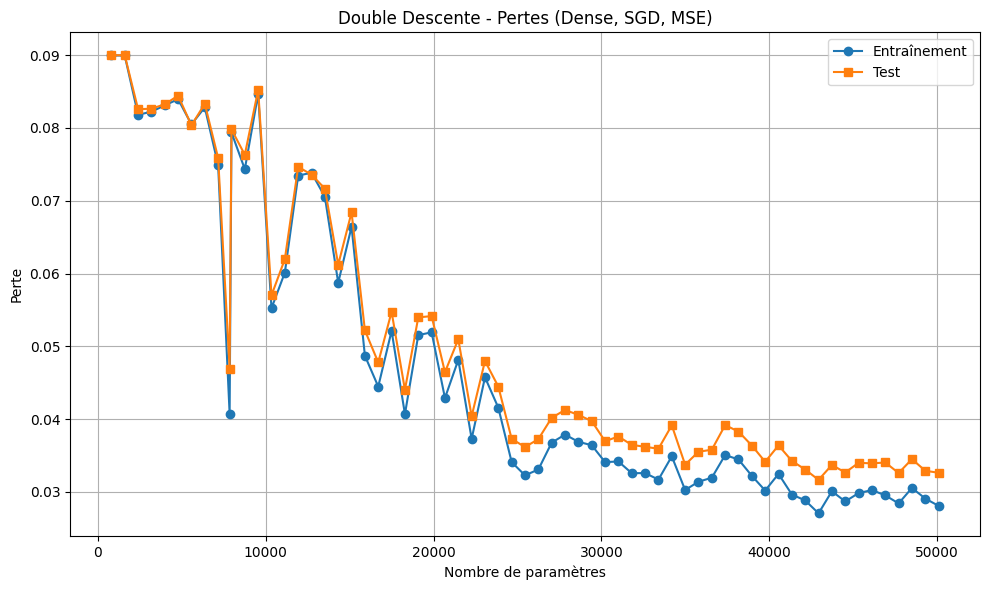

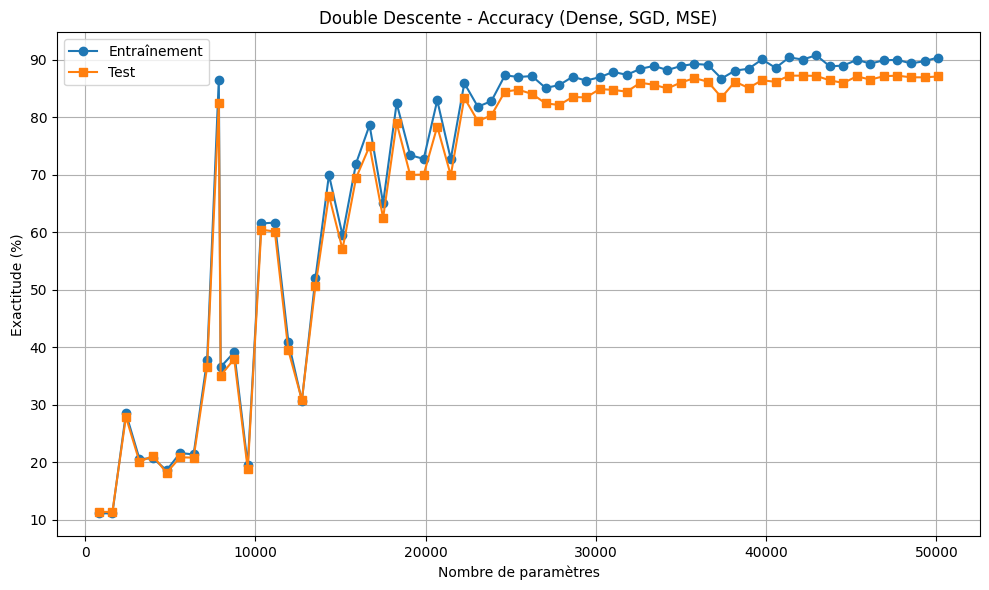

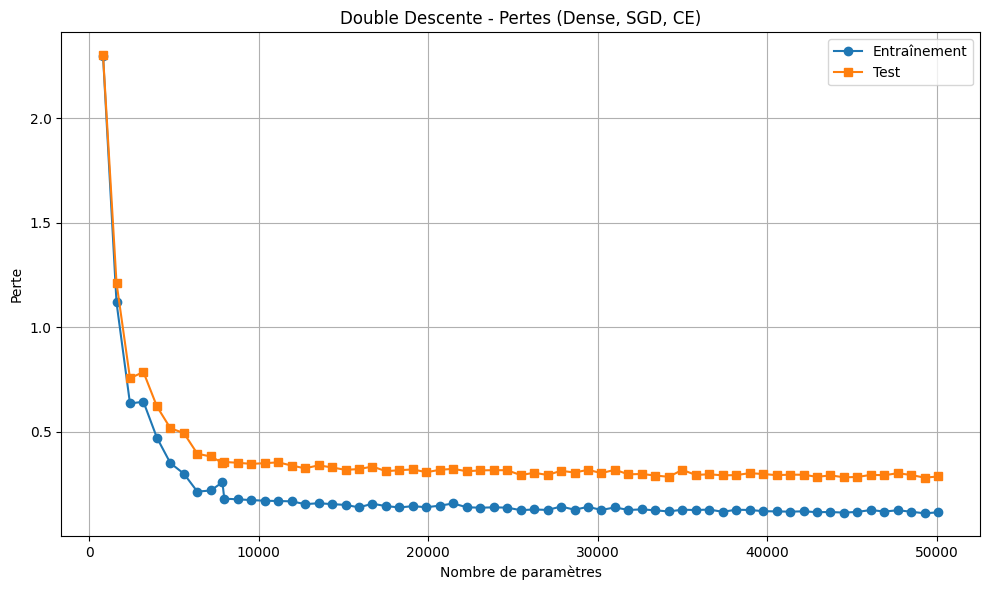

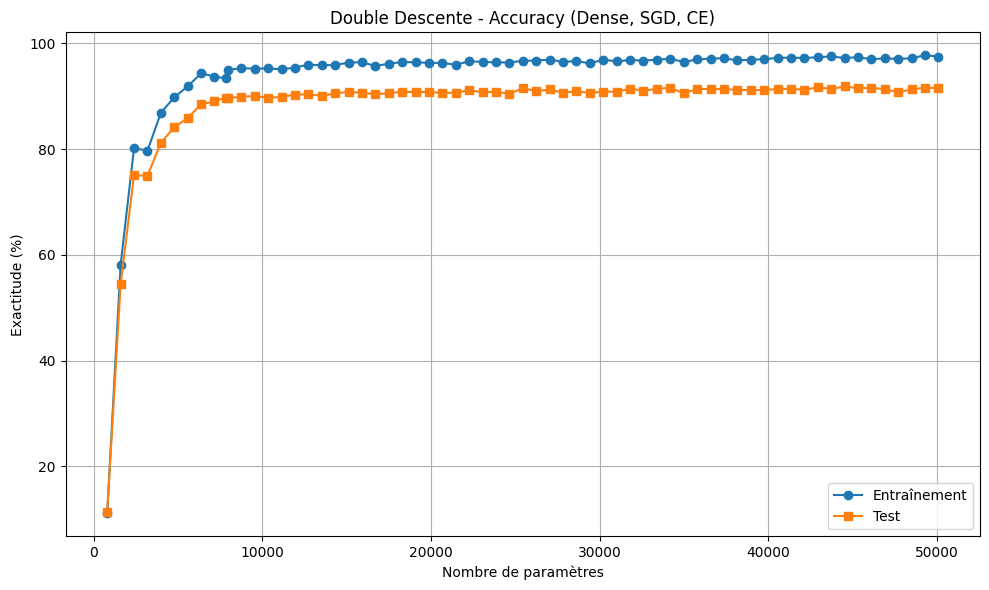

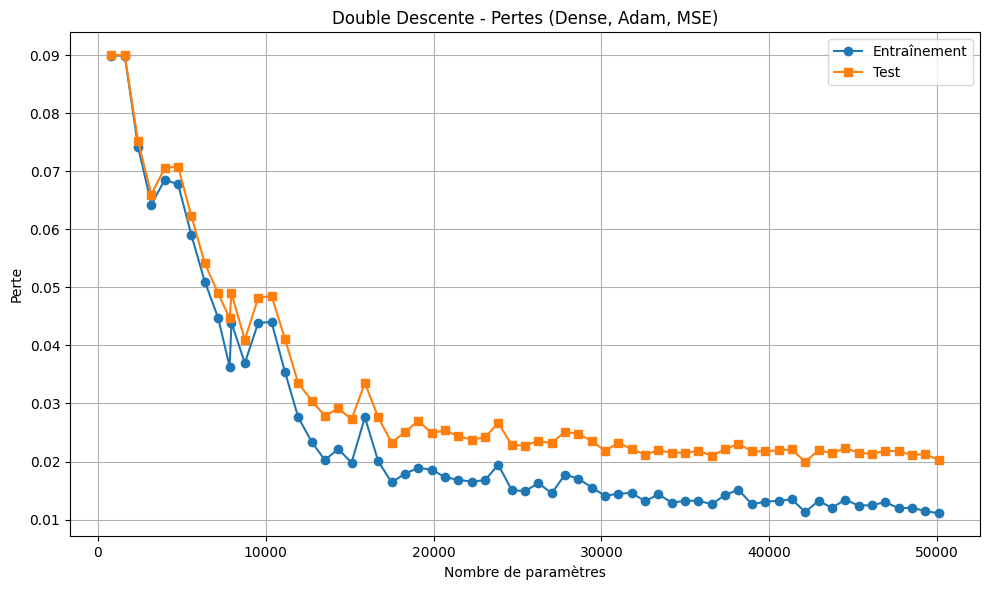

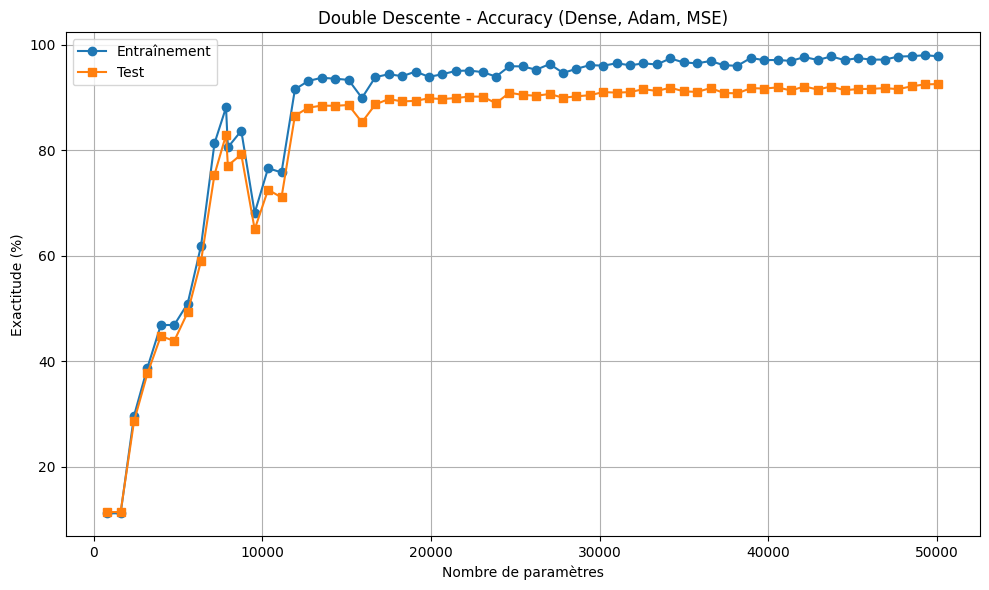

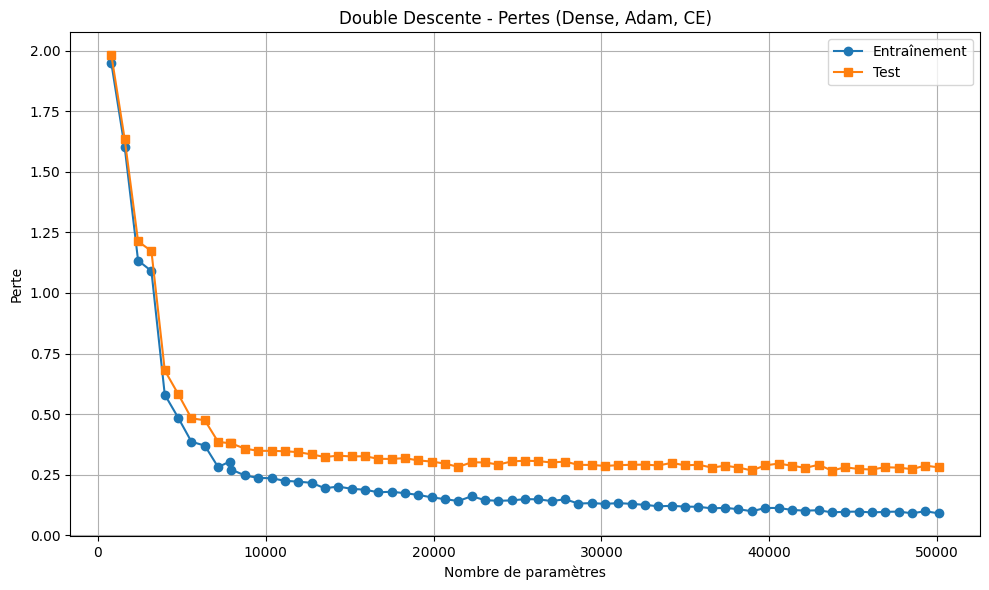

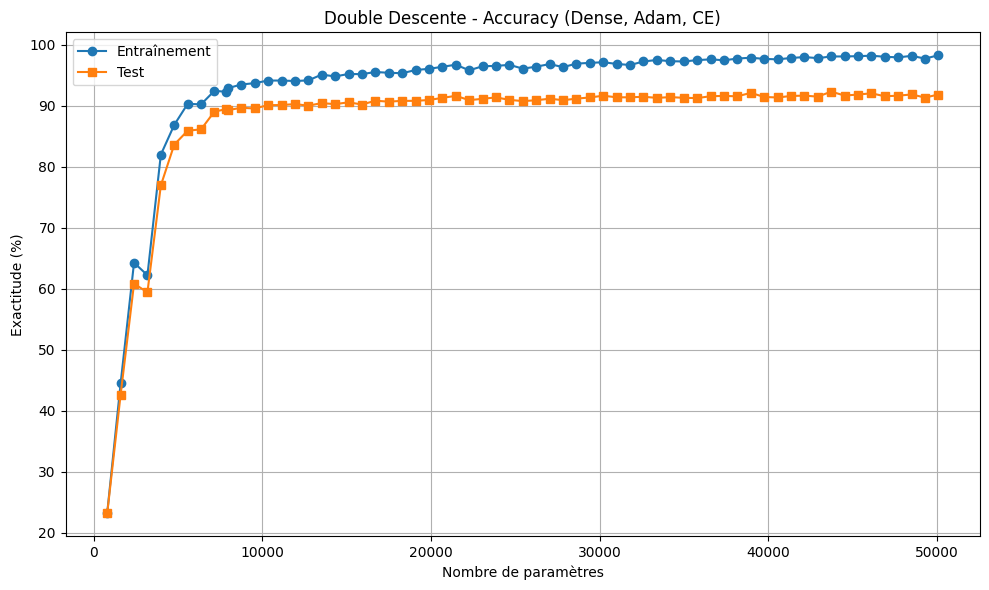

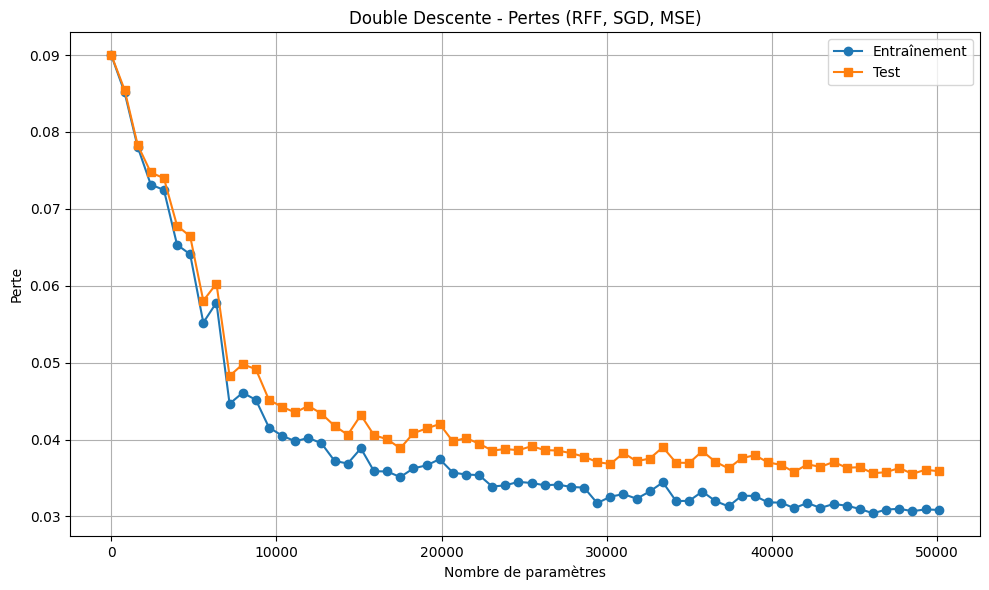

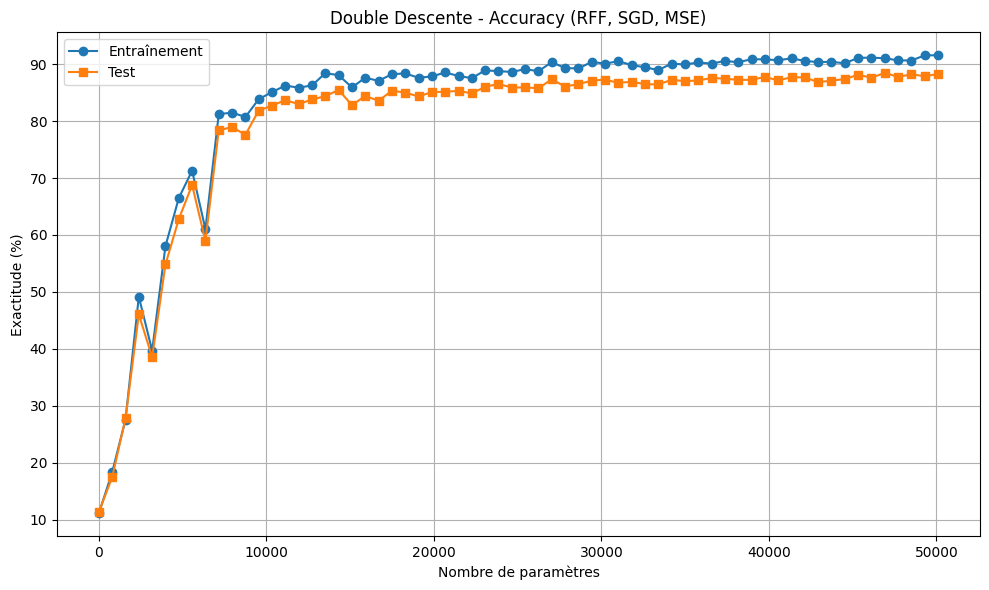

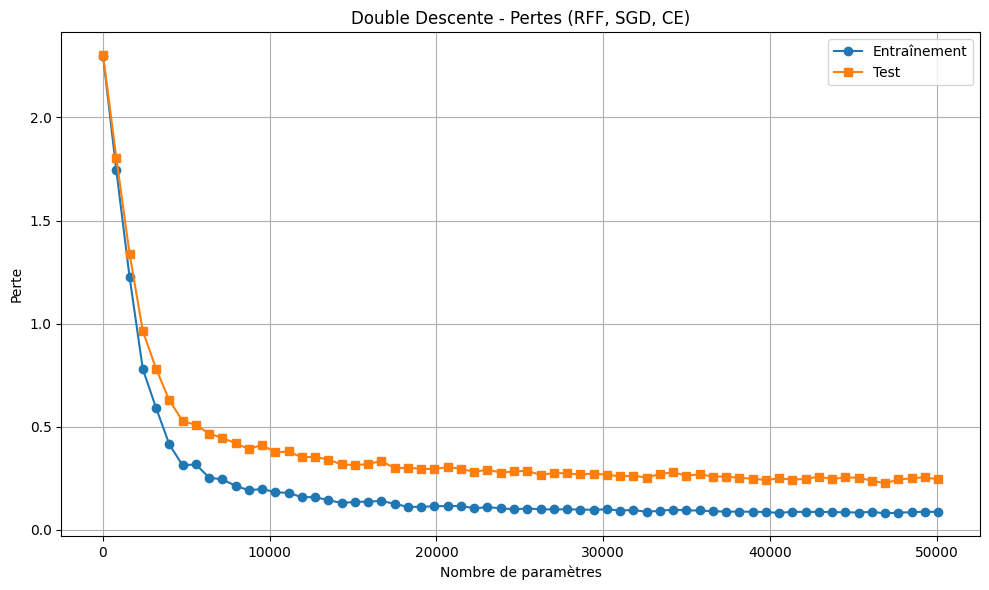

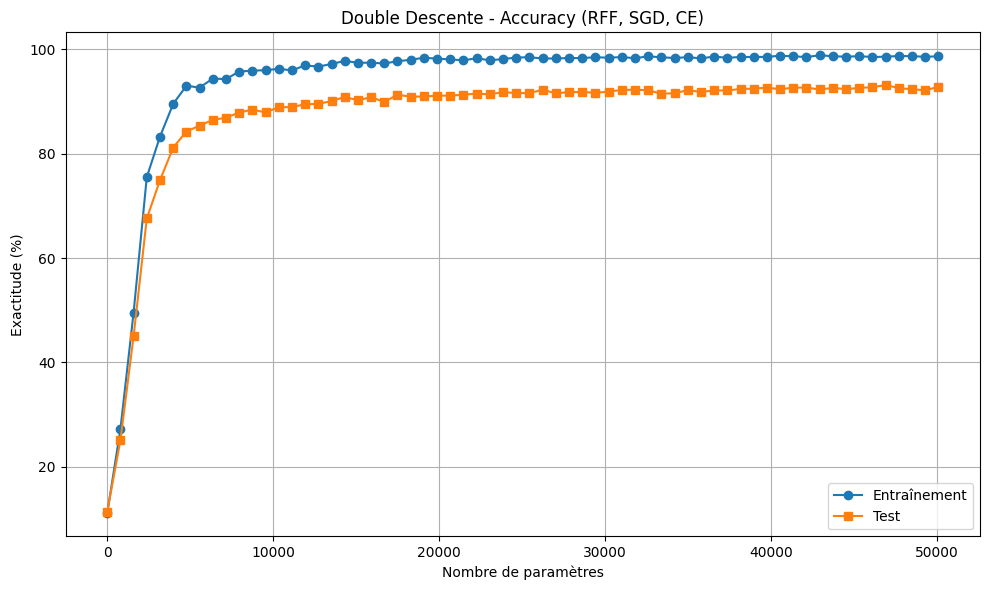

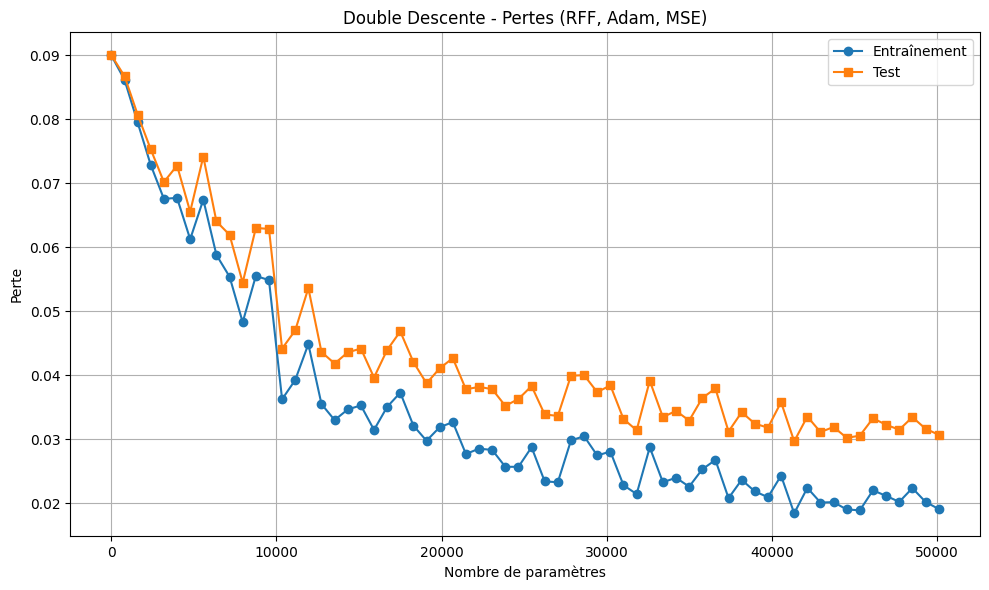

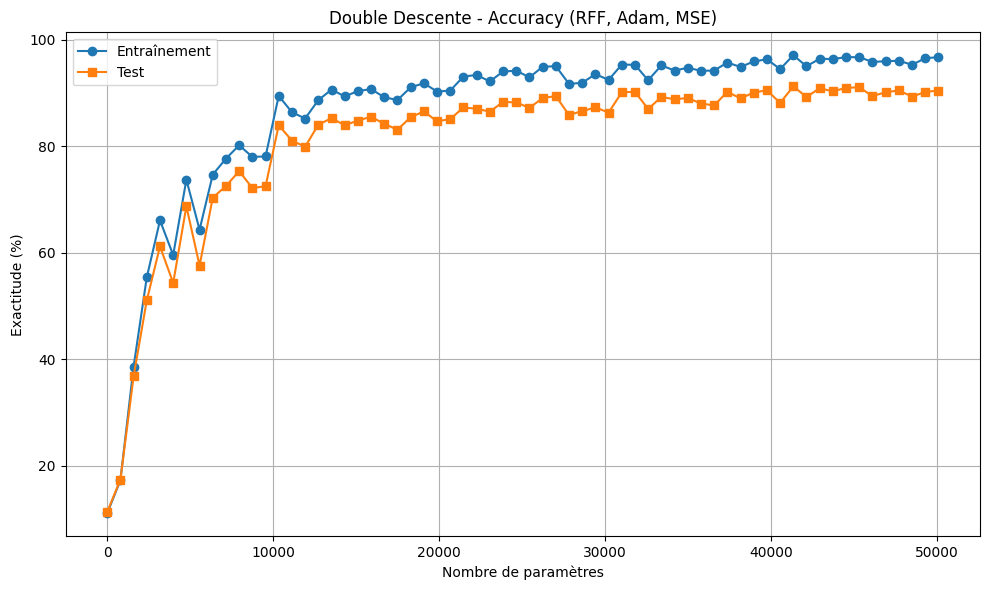

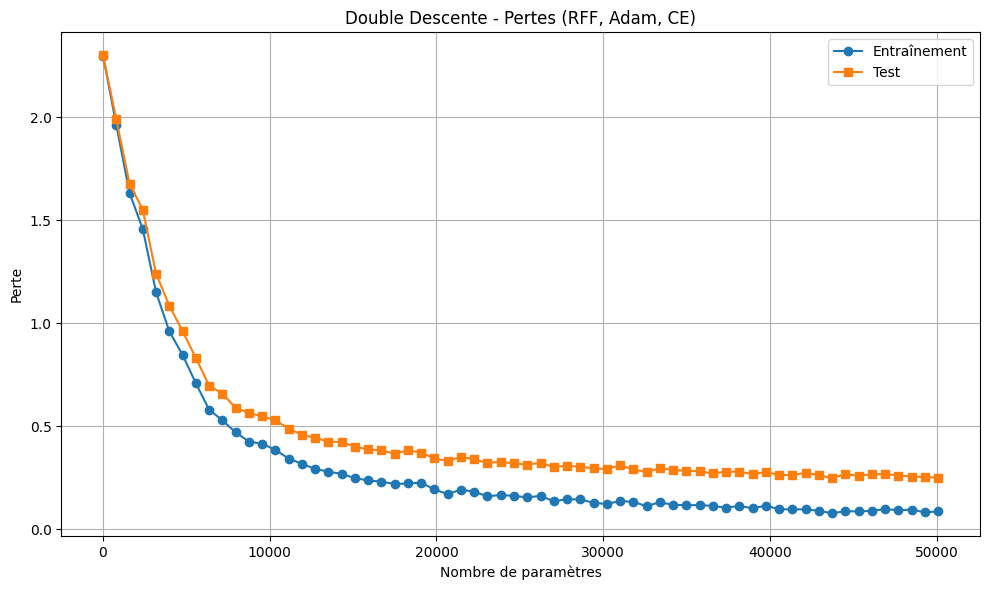

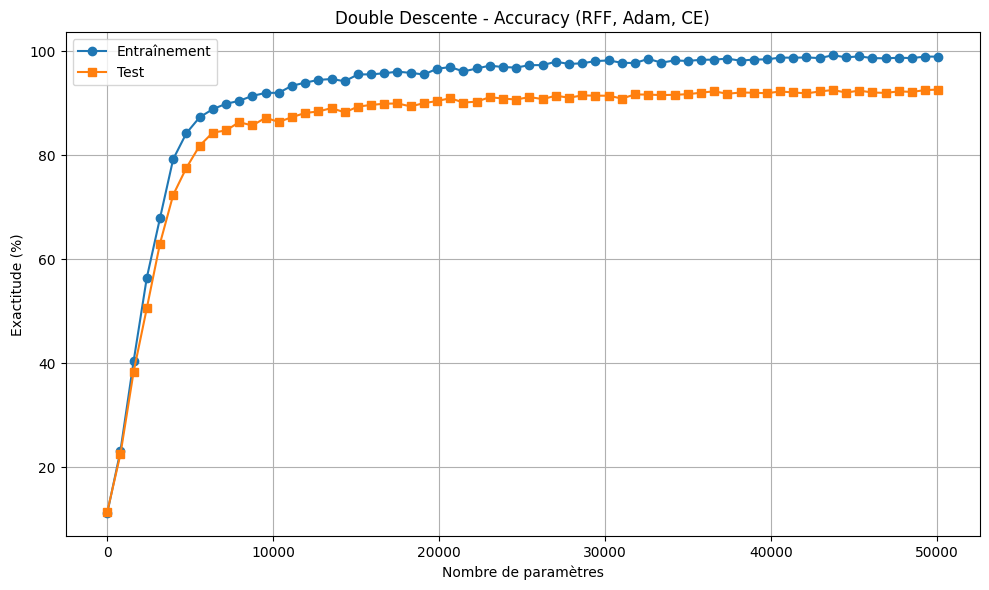

Expérience terminée. Consultez df_results pour les statistiques détaillées.


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
from keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import pandas as pd


# ------------------------------------------------
# 1. Chargement et Prétraitement des Données MNIST
# ------------------------------------------------

(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# On réduit volontairement le dataset pour exacerber le phénomène de double descente
train_images = train_images[:4000]
train_labels = train_labels[:4000]

# Normalisation
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Flatten (pour réseau dense ou RFF)
train_images_flat = train_images.reshape((-1, 28 * 28))
test_images_flat = test_images.reshape((-1, 28 * 28))


# ----------------------------------------
# 2. Fonctions pour Créer les Modèles
# ----------------------------------------

def create_dense_model(n_hidden_units, activation='relu'):
    """
    Crée un réseau dense à 1 couche cachée de n_hidden_units
    + 1 couche de sortie (10 neurones).
    """
    # Cas particulier : si n_hidden_units == 0,
    # on met directement une seule couche Dense(10) (pas de couche cachée).
    if n_hidden_units == 0:
        model = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(10, activation='linear')
        ])
    else:
        model = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(n_hidden_units, activation=activation),
            layers.Dense(10, activation='linear')
        ])
    return model


def create_rff_model(n_components, activation='cos'):
    """
    Exemple simplifié de Random Fourier Features :
    Ici, on simule la projection aléatoire par une Dense "gelée"
    + cos() sur la sortie, puis une Dense(10).
    
    NB : Dans la pratique, on gèlerait la couche RFF (trainable=False)
    pour de "vraies" RFF, mais ici on la laisse entraînable pour comparer
    avec la version Dense "classique".
    """
    # Pour rester simple, on va juste reproduire la même forme
    # de calcul du nombre de paramètres que create_dense_model,
    # avec ou sans activation cos() (optionnel).
    # 
    # Dans un vrai RFF, on ferait :
    #   - W ~ N(0, gamma^2 I)
    #   - b ~ Uniform(0, 2pi)
    #   - projection = cos(Wx + b)
    #   - Dense(10)
    # Mais ici, restons minimalistes.
    
    inputs = layers.Input(shape=(784,))
    # Couche "projet" (équivalent RFF), trainable par simplicité :
    proj = layers.Dense(n_components, use_bias=True)(inputs)
    if activation == 'cos':
        proj = layers.Lambda(lambda x: tf.math.cos(x))(proj)
    # Couche de sortie
    outputs = layers.Dense(10, activation='linear')(proj)
    
    model = keras.Model(inputs, outputs)
    return model


# ---------------------------
# 3. Configuration Générale
# ---------------------------

# Pour varier plus largement, on crée ci-dessous une liste
# de neurones cachés allant de 0 à 63 (pour un total de paramètres
# allant d'environ 7,850 à ~50k).
n_hidden_units_list = list(range(0, 64))  # 0..63

# Idem pour le RFF : n_components = 0..63
n_components_list = list(range(0, 64))

model_types = ['Dense', 'RFF']

optimizers_dict = {
    'SGD': {
        'class': optimizers.SGD,
        'params': {'learning_rate': 0.01, 'momentum': 0.95}
    },
    'Adam': {
        'class': optimizers.Adam,
        'params': {'learning_rate': 0.001}
    }
}

loss_functions_dict = {
    'MSE': losses.MeanSquaredError(),
    'CE': losses.SparseCategoricalCrossentropy(from_logits=True)
}

max_epochs = 20  # On peut ajuster ce nombre d'époques


# ------------------------------------
# 4. Dictionnaire pour Sauvegarder les Résultats
# ------------------------------------

results = {
    'model': [],
    'optimizer': [],
    'loss_function': [],
    'n_hidden_units_or_rff': [],
    'n_parameters': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'training_time': []
}


# ------------------------------------
# 5. Boucles d'Entraînement / Évaluation
# ------------------------------------

print("Processing calculations...")

for model_type in model_types:
    for optimizer_name, optimizer_info in optimizers_dict.items():
        optimizer_class = optimizer_info['class']
        optimizer_params = optimizer_info['params']
        for loss_name, loss_fn in loss_functions_dict.items():
            
            if model_type == 'Dense':
                iterable_list = n_hidden_units_list
                desc_name = f"{model_type}-{optimizer_name}-{loss_name}"
                
            else:  # RFF
                iterable_list = n_components_list
                desc_name = f"{model_type}-{optimizer_name}-{loss_name}"
            
            for n_units in tqdm(iterable_list, desc=f"Modèles {desc_name}"):
                
                start_time = time.time()
                
                # Création de l'optimiseur
                optimizer = optimizer_class(**optimizer_params)
                
                # Création du modèle
                if model_type == 'Dense':
                    model = create_dense_model(n_units, activation='relu')
                else:
                    model = create_rff_model(n_units, activation='cos')
                
                # Compilation
                model.compile(optimizer=optimizer,
                              loss=loss_fn,
                              metrics=['accuracy'])
                
                # Option : LearningRateScheduler pour ajuster le LR
                def scheduler(epoch, lr):
                    # Exemple : on diminue le LR toutes les 10 époques
                    if (epoch + 1) % 10 == 0:
                        return lr * 0.9
                    else:
                        return lr
                
                lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
                
                # Entraînement
                history = model.fit(
                    train_images_flat,
                    tf.one_hot(train_labels, 10) if loss_name == 'MSE' else train_labels,
                    epochs=max_epochs,
                    batch_size=128,
                    verbose=0,
                    callbacks=[lr_scheduler]
                )
                
                # Évaluation
                if loss_name == 'MSE':
                    train_loss, train_acc = model.evaluate(
                        train_images_flat, tf.one_hot(train_labels, 10), verbose=0
                    )
                    test_loss, test_acc = model.evaluate(
                        test_images_flat, tf.one_hot(test_labels, 10), verbose=0
                    )
                else:
                    train_loss, train_acc = model.evaluate(
                        train_images_flat, train_labels, verbose=0
                    )
                    test_loss, test_acc = model.evaluate(
                        test_images_flat, test_labels, verbose=0
                    )
                
                # Nombre total de paramètres
                n_params = model.count_params()
                
                # Sauvegarde dans le dictionnaire
                results['model'].append(model_type)
                results['optimizer'].append(optimizer_name)
                results['loss_function'].append(loss_name)
                results['n_hidden_units_or_rff'].append(n_units)
                results['n_parameters'].append(n_params)
                results['train_losses'].append(train_loss)
                results['test_losses'].append(test_loss)
                results['train_accuracies'].append(train_acc * 100)
                results['test_accuracies'].append(test_acc * 100)
                
                elapsed_time = time.time() - start_time
                results['training_time'].append(
                    time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
                )
                '''
                print(f"Terminé : {model_type}-{optimizer_name}-{loss_name} | "
                      f"Units/RFF: {n_units}, Paramètres: {n_params}, "
                      f"TrainAcc: {train_acc*100:.2f}%, TestAcc: {test_acc*100:.2f}%, "
                      f"Temps: {elapsed_time:.2f}s")
                '''

# ------------------------------------
# 6. Création d'un DataFrame de Résultats
# ------------------------------------

df_results = pd.DataFrame(results)


# ------------------------------------
# 7. Fonction de Visualisation
# ------------------------------------

def plot_double_descent(df, model_type, optimizer, loss_function):
    """
    Trace la courbe de perte et la courbe d'accuracy
    en fonction du nombre de paramètres (pour un triplet
    model_type / optimizer / loss_function donné).
    """
    subset = df[(df['model'] == model_type) &
                (df['optimizer'] == optimizer) &
                (df['loss_function'] == loss_function)]
    
    # Tri par nombre de paramètres (important pour un tracé correct)
    subset = subset.sort_values(by='n_parameters')
    
    plt.figure(figsize=(10, 6))
    plt.plot(subset['n_parameters'], subset['train_losses'], marker='o', label='Entraînement')
    plt.plot(subset['n_parameters'], subset['test_losses'], marker='s', label='Test')
    plt.xlabel('Nombre de paramètres')
    plt.ylabel('Perte')
    plt.title(f'Double Descente - Pertes ({model_type}, {optimizer}, {loss_function})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(subset['n_parameters'], subset['train_accuracies'], marker='o', label='Entraînement')
    plt.plot(subset['n_parameters'], subset['test_accuracies'], marker='s', label='Test')
    plt.xlabel('Nombre de paramètres')
    plt.ylabel('Exactitude (%)')
    plt.title(f'Double Descente - Accuracy ({model_type}, {optimizer}, {loss_function})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------------------------------------
# 8. Visualisation des Résultats
# ------------------------------------
for mtype in model_types:
    for opt_name in optimizers_dict.keys():
        for loss_name in loss_functions_dict.keys():
            plot_double_descent(df_results, mtype, opt_name, loss_name)

print("Expérience terminée. Consultez df_results pour les statistiques détaillées.")